In [2]:
%load_ext autoreload
%autoreload 2
from pipeline import get_maps, normalized, normalized_k, normalized_all, gen_maps
from helpers import load_image, load_image2

import numpy as np

import matplotlib.pyplot as plt
#%autoreload 2
%matplotlib inline

#Datastructure
from collections import OrderedDict

import skimage


DATA_PATH = '../data/'

In [7]:
source_path='/city/7.jpg'
style_path='/city/3.jpg'
K = 5

#Hs, Ws = gen_maps(source_path, style_path, K, up_width=400, layer_name="conv3_4", normalize_per_k=True)


In [99]:
def image_stats(image):
    (l, a, b) = np.split(img_s_lab, 3, axis=2)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())
    
    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

#https://www.pyimagesearch.com/2014/06/30/super-fast-color-transfer-images/
def color_transfer(source, target):
    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)
    
    # subtract the means from the target image
    (l, a, b) = np.split(target, 3, axis=2)
    l = l[:,:,0]
    a = a[:,:,0]
    b = b[:,:,0]
    
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar
    
    l = (lStdTar / lStdSrc) * l
    a = (aStdTar / aStdSrc) * a
    b = (bStdTar / bStdSrc) * b
    
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc
    
    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)
    
    transfer = np.array([l, a, b])
    transfer = np.swapaxes(transfer, axis1=0, axis2=2)
    transfer = np.swapaxes(transfer, axis1=0, axis2=1)
    
    transfer = skimage.color.lab2rgb(transfer)
    
    # return the color transferred image
    return transfer


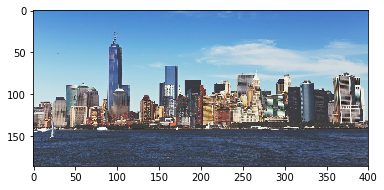

In [97]:
img_content = load_image2(DATA_PATH + source_path, width=400)
img_style = load_image2(DATA_PATH + style_path, width=400)

plt.imshow(img_content)

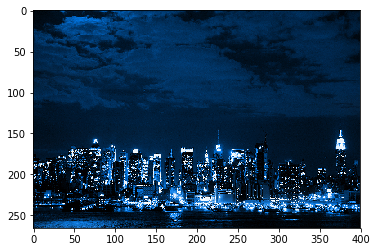

In [98]:
plt.imshow(img_style)

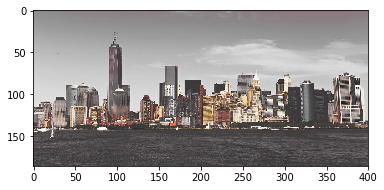

In [101]:
img_c_lab = skimage.color.rgb2lab(img_content)
img_s_lab = skimage.color.rgb2lab(img_style)
#img_s_lab[:,:,0].max()

t = color_transfer(img_s_lab, img_c_lab)
plt.imshow(t)